# Executive Compensation Dataset:

The executive compensation dataset contains detailed information about the payments made by not-for-profits to its highest compensated employees.  Thresholds include - officers, directors, trustees, key employees (>150K), and five highest compensated (>100K) employees.

In [42]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import plotly.express as px

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## IMPORT DATA & PREPROCESS

In [58]:
# import USA state abbreviations 
# and median income for each state data
us_state_abb = pd.read_csv('02.data/us_states.csv', index_col=0)
median_income_by_state = pd.read_csv('02.data/median_income_by_state.csv',
                                     skiprows=lambda x: x in [0, 1, 3], 
                                     skipfooter=9, engine='python', index_col=0)

median_income_by_state = us_state_abb.merge(median_income_by_state,
               left_index=True,
               right_index=True)

In [84]:
median_income_by_state_dict = dict(zip(median_income_by_state.Abbreviation,
median_income_by_state.state_median_income))

In [44]:
# import compensation dataset with full columns
df_original = pd.read_csv('02.data/primary_raw_datasets/Compensation_charities_Open990.csv', 
                 header=1, nrows=5)

In [101]:
df_original.head(1)

,EIN,Period,Person ID,Title,Hours,Hours related org,Trustee or director,Institutional trustee,Officer,Key employee,Highest compensated,Former,Reportable comp,Reportable comp related org,Other comp all,Health and benefits,Other comp,Base,Base related org,Bonus,Bonus related org,Other,Other related org,Retire,Retire related org,Nontax benefit,Nontax benefit related org,Sum comp,Sum comp related org,Prior deferred,Prior deferred related org,Org name,Subsection,NTEE code,NTEE description,Street,City,State,ZIP,Formation yr,Phone,Website,Assets,Liabilities,Expenses,Revenue,Form type,Efile ID
0,10877614,201712,y7drw7umAm8SK9fWY7aFCA,BOARD MEMBER,1.0,NaN,True,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",4201 E 16TH ST,INDIANAPOLIS,IN,46201,2006,3174960916,WWW.HEARTCHANGEINDY.ORG,2112293,92283,500749,1792933,990,201803199349308805


In [252]:
# import columns that interest me
cols = ['EIN',
       'Period',
       'Title',
        'Hours', 
       'Trustee or director',
       'Institutional trustee',
        'Officer',
        'Key employee',
        'Highest compensated',
        'Reportable comp',
        'Health and benefits',
        'Other comp',
       'Sum comp', 
        'Org name',
        'Subsection',
        'NTEE code',
        'NTEE description',
       'State',
       'Formation yr',
       'Assets',
        'Liabilities',
        'Expenses',
        'Revenue']

df = pd.read_csv('02.data/primary_raw_datasets/Compensation_charities_Open990.csv', 
                 header=1,
                usecols=cols)

In [253]:
df.shape

(3990749, 23)

In [254]:
# convert column labels to lower case and remove spaces from column names
df.columns = df.columns.str.replace(' ', '_')
df.columns = map(str.lower, df.columns)

In [255]:
# add median income for the state of each not-for-profit

%timeit()

df = df.merge(median_income_by_state,
        left_on='state',
        right_on='Abbreviation').drop('Abbreviation', axis=1)

9.32 ns ± 1.88 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


In [256]:
# rather than use pandas merge to 
# join in median income for each state
# how does the performance of a dictionary compare?

%timeit()

df['state_median_income'] = df.state.apply(lambda x: median_income_by_state_dict[x])

8.18 ns ± 0.504 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


### Narrow dataset based on hours and earnings for each employee

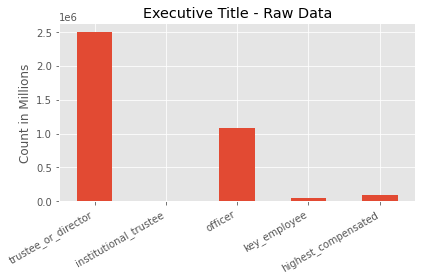

In [257]:
# what is the distribution
# based on the title of the person receiving the compensation?
df.loc[:, 'trustee_or_director': 'highest_compensated'].notnull().sum().plot(kind='bar')
plt.xticks(rotation=30, horizontalalignment="right")
plt.ylabel('Count in Millions')
plt.title('Executive Title - Raw Data')
plt.tight_layout()

plt.savefig('03.visualizations/exec_title_1.png');

In [258]:
# exclude people who make less than median income
# for the state the the not-for-profit is located in
df = df[(df.reportable_comp > df.state_median_income) &
       (df.hours >= 40)]

By excluding people who make less than the median income for the state the not-for-profit is located in, and by excluding anyone who works less than 40 hours a week, I feel confident I am only including core executive management versus part time board members or trustees.

In [259]:
# examine size of dataset
df.shape

(206706, 24)

### Narrow dataset based on title of employee

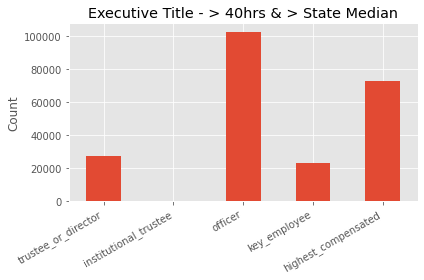

In [260]:
# what is the distribution
# based on the title of the person receiving the compensation?
df.loc[:, 'trustee_or_director': 'highest_compensated'].notnull().sum().plot(kind='bar')
plt.xticks(rotation=30, horizontalalignment="right")
plt.ylabel('Count')
plt.title('Executive Title - > 40hrs & > State Median')
plt.tight_layout()
plt.savefig('03.visualizations/exec_title_2.png');

Based on people who appear to be getting paid for a full time position and who are also working more than 40 hours a week, officer has the highest count.

In [261]:
df.loc[df.officer == True, 'title'].value_counts().head()

EXECUTIVE DIRECTOR    11400
PRESIDENT              5391
CEO                    5127
EXECUTIVE DI           4049
CFO                    3624
Name: title, dtype: int64

In [262]:
df.loc[df.trustee_or_director == True, 'title'].value_counts().head()

PRESIDENT             2283
EXECUTIVE DIRECTOR    2280
DIRECTOR              1149
EXECUTIVE DI          1095
President             1052
Name: title, dtype: int64

In [263]:
df.loc[df.key_employee == True, 'title'].value_counts().head()

EXECUTIVE DIRECTOR    1155
Executive Director     967
CEO                    326
GENERAL MANAGER        244
PRESIDENT              233
Name: title, dtype: int64

In [264]:
df.loc[df.highest_compensated == True, 'title'].value_counts().head(10)

PHYSICIAN             5160
Physician             1685
EXECUTIVE DIRECTOR     926
EMPLOYEE               819
Executive Director     663
CONTROLLER             547
PSYCHIATRIST           527
PHARMACIST             452
DENTIST                368
MEDICAL DIRECTOR       366
Name: title, dtype: int64

By examination of the titles of "Highest Compensated" employees, most of these are highly skilled trades, versus executive leadership.  As a result I will exclude people who fall into this category.

In [265]:
# drop highest compensated employees
df.drop(df.loc[df.highest_compensated == True].index, inplace=True)

In [266]:
# how many executives remain?
df.shape

(133451, 24)

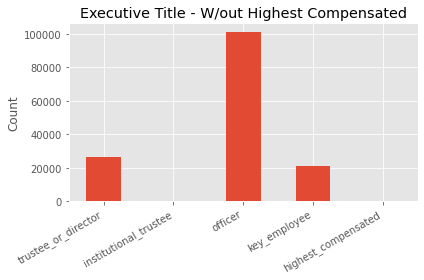

In [267]:
# what is the distribution
# based on the title of the person receiving the compensation?
df.loc[:, 'trustee_or_director': 'highest_compensated'].notnull().sum().plot(kind='bar')
plt.xticks(rotation=30, horizontalalignment="right")
plt.ylabel('Count')
plt.title('Executive Title - W/out Highest Compensated')
plt.tight_layout()
plt.savefig('03.visualizations/exec_title_3.png');

In [268]:
# examine for nan values
df.isna().sum()

ein                           0
period                        0
title                      4085
hours                         0
trustee_or_director      106664
institutional_trustee    133359
officer                   32224
key_employee             112204
highest_compensated      133451
reportable_comp               0
health_and_benefits      132811
other_comp               132921
sum_comp                  63775
org_name                      0
subsection                    0
ntee_code                   189
ntee_description            190
state                         0
formation_yr               4729
assets                        0
liabilities                 247
expenses                      0
revenue                       9
state_median_income           0
dtype: int64

In [269]:
# drop rows with missing values in these columns
df.dropna(subset=['ntee_code'], inplace=True)

In [270]:
# fillna for formation_year
# I may want to do this with random forest instead
df.formation_yr.fillna(df.formation_yr.median(), inplace=True)
df.formation_yr = df.formation_yr.astype(int)

In [271]:
# fillna for orgs with missing liabilities & revenue
df.liabilities.fillna(df.liabilities.median(), inplace=True)
df.revenue.fillna(df.revenue.median(), inplace=True)

In [272]:
# examine columns with missing values
df.isna().mean()

ein                      0.000000
period                   0.000000
title                    0.030654
hours                    0.000000
trustee_or_director      0.799605
institutional_trustee    0.999317
officer                  0.241224
key_employee             0.840757
highest_compensated      1.000000
reportable_comp          0.000000
health_and_benefits      0.995220
other_comp               0.996045
sum_comp                 0.478058
org_name                 0.000000
subsection               0.000000
ntee_code                0.000000
ntee_description         0.000008
state                    0.000000
formation_yr             0.000000
assets                   0.000000
liabilities              0.000000
expenses                 0.000000
revenue                  0.000000
state_median_income      0.000000
dtype: float64

In [273]:
# drop columns with a high amount of null values
df.drop([
    'health_and_benefits',
    'other_comp',
    'sum_comp'        
], axis=1, inplace=True)

## PRELIMINARY EDA

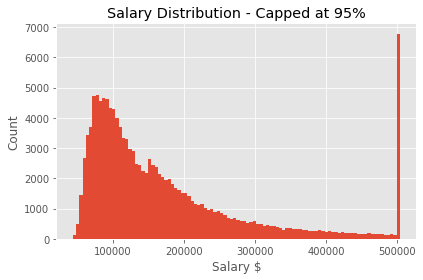

In [274]:
# clipping at the 95% percentile, what is the distribution?

df.reportable_comp.clip(upper=df.reportable_comp.quantile(.95)).hist(bins=100)
plt.title('Salary Distribution - Capped at 95%')
plt.xlabel('Salary $')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('03.visualizations/salary_dist.png');

The reason for the spike at 100K is because that is the threshold above which not-for-profit organizations are required to disclose salaries.  Clearly a large number of organizations are disclosing, even when not required.

## FEATURE ENGINEERING

#### Remove noise from NTEE codes

In [240]:
df.head()

,ein,period,title,hours,trustee_or_director,institutional_trustee,officer,key_employee,highest_compensated,reportable_comp,org_name,subsection,ntee_code,ntee_description,state,formation_yr,assets,liabilities,expenses,revenue,state_median_income
6,10877614,201712,BOARD MEMBER/MANAGING D,65.0,True,NaN,NaN,NaN,NaN,55385.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006,2112293,92283.0,500749.0,1792933.0,54181
7,10877614,201712,BOARD MEMBER,40.0,True,NaN,NaN,NaN,NaN,60000.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006,2112293,92283.0,500749.0,1792933.0,54181
24,10945309,201712,CFO,40.0,NaN,NaN,True,NaN,NaN,101486.0,Jane Pauley Community Health Center Inc,501(c)(3),E32,"Ambulatory Health Center, Community Clinic",IN,2009,20015611,20848801.0,24155447.0,22357380.0,54181
25,10945309,201712,Director of IS & Quality I,40.0,NaN,NaN,True,NaN,NaN,103819.0,Jane Pauley Community Health Center Inc,501(c)(3),E32,"Ambulatory Health Center, Community Clinic",IN,2009,20015611,20848801.0,24155447.0,22357380.0,54181
27,10945309,201712,Medical Director,40.0,NaN,NaN,True,NaN,NaN,256928.0,Jane Pauley Community Health Center Inc,501(c)(3),E32,"Ambulatory Health Center, Community Clinic",IN,2009,20015611,20848801.0,24155447.0,22357380.0,54181


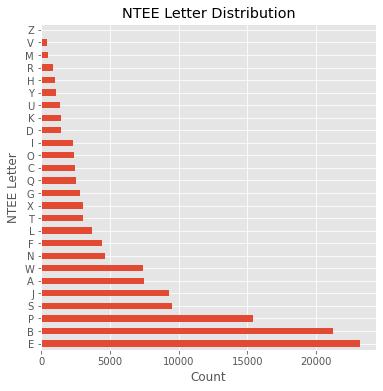

In [241]:
# examine NTEE code distribution based on letter only
df.ntee_code.apply(lambda x: str(x)[0]).value_counts().plot(kind='barh', figsize=(6, 6))
plt.ylabel('NTEE Letter')
plt.xlabel('Count')
plt.title('NTEE Letter Distribution')
plt.savefig('03.visualizations/ntee_letter.png');

Based on this article, NTEE letters are broadly categorized into 10 groups.  Organizing them into these groups will further reduce categories.

https://nccs.urban.org/project/national-taxonomy-exempt-entities-ntee-codes

    I. Arts, Culture, and Humanities - A
    II. Education - B
    III. Environment and Animals - C, D
    IV. Health - E, F, G, H
    V. Human Services - I, J, K, L, M, N, O, P
    VI. International, Foreign Affairs - Q
    VII. Public, Societal Benefit - R, S, T, U, V, W
    VIII. Religion Related - X
    IX. Mutual/Membership Benefit - Y
    X. Unknown, Unclassified - Z

In [242]:
# function to subdivide ntee letters based on categories

def summarize_ntee(x):
    if x in'A':
        return 'Arts, Culture, and Humanities'
    if x in 'B':
        return 'Education'
    if x in 'C, D':
        return 'Environment and Animals'
    if x in 'E, F, G, H':
        return 'Health'
    if x in 'I, J, K, L, M, N, O, P':
        return 'Human Services'
    if x in 'Q':
        return 'International, Foreign Affairs'
    if x in 'R, S, T, U, V, W':
        return 'Public, Societal Benefit'
    if x in 'X':
        return 'Religion Related'
    if x in 'Y':
        return 'Mutual/Membership Benefit'
    if x in 'Z':
        return 'Unknown, Unclassified'

In [278]:
df['ntee_categories'] = df.ntee_code.apply(lambda x: str(x)[0]).apply(summarize_ntee)

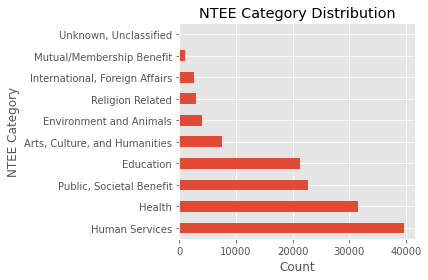

In [279]:
# examine distribution of categorization
df.ntee_categories.value_counts().plot(kind='barh')
plt.ylabel('NTEE Category')
plt.xlabel('Count')
plt.title('NTEE Category Distribution')
plt.tight_layout()
plt.savefig('03.visualizations/ntee_category.png');

#### Find percentage of total executive compensation for each org for each executive paid


In [245]:
# find total reportable comp for each ein
df.groupby('ein')['reportable_comp'].sum().astype(int).rename('total_ex_comp_per_company')

ein
10021545     198085
10024245      87550
10024645      64575
10029480      62180
10043280     130513
              ...  
996009349    103447
996009889    172346
996012378    103660
996015708    193873
996016434     88013
Name: total_ex_comp_per_company, Length: 69947, dtype: int32

In [280]:
# join this amount based on ein
# to each person who was paid
df = df.merge(df.groupby('ein')['reportable_comp']
              .sum()
              .astype(int)
              .rename('total_ex_comp_per_company'),
        left_on='ein',
        right_on='ein')

In [248]:
df.head()

,ein,period,title,hours,trustee_or_director,institutional_trustee,officer,key_employee,highest_compensated,reportable_comp,org_name,subsection,ntee_code,ntee_description,state,formation_yr,assets,liabilities,expenses,revenue,state_median_income,ntee_categories,total_ex_comp_per_company
0,10877614,201712,BOARD MEMBER/MANAGING D,65.0,True,NaN,NaN,NaN,NaN,55385.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006,2112293,92283.0,500749.0,1792933.0,54181,Health,115385
1,10877614,201712,BOARD MEMBER,40.0,True,NaN,NaN,NaN,NaN,60000.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006,2112293,92283.0,500749.0,1792933.0,54181,Health,115385
2,10945309,201712,CFO,40.0,NaN,NaN,True,NaN,NaN,101486.0,Jane Pauley Community Health Center Inc,501(c)(3),E32,"Ambulatory Health Center, Community Clinic",IN,2009,20015611,20848801.0,24155447.0,22357380.0,54181,Health,741963
3,10945309,201712,Director of IS & Quality I,40.0,NaN,NaN,True,NaN,NaN,103819.0,Jane Pauley Community Health Center Inc,501(c)(3),E32,"Ambulatory Health Center, Community Clinic",IN,2009,20015611,20848801.0,24155447.0,22357380.0,54181,Health,741963
4,10945309,201712,Medical Director,40.0,NaN,NaN,True,NaN,NaN,256928.0,Jane Pauley Community Health Center Inc,501(c)(3),E32,"Ambulatory Health Center, Community Clinic",IN,2009,20015611,20848801.0,24155447.0,22357380.0,54181,Health,741963


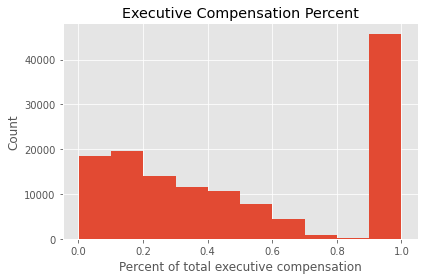

In [251]:
plt.hist(df.reportable_comp/df.total_ex_comp_per_company)
plt.xlabel('Percent of total executive compensation')
plt.ylabel('Count')
plt.title('Executive Compensation Percent')
plt.tight_layout()
plt.savefig('03.visualizations/execs_per_company.png');

Executives are clearly bifurcated between those who are the only executive with that organization and those who are part of a larger organization with lots of executives.

### EXPORT DATASET FOR MODELING

cleaned/organized dataset with added features - export for modeling

In [282]:
# select columns to use for modeling
list(enumerate(df.columns))

[(0, 'ein'),
 (1, 'period'),
 (2, 'title'),
 (3, 'hours'),
 (4, 'trustee_or_director'),
 (5, 'institutional_trustee'),
 (6, 'officer'),
 (7, 'key_employee'),
 (8, 'highest_compensated'),
 (9, 'reportable_comp'),
 (10, 'org_name'),
 (11, 'subsection'),
 (12, 'ntee_code'),
 (13, 'ntee_description'),
 (14, 'state'),
 (15, 'formation_yr'),
 (16, 'assets'),
 (17, 'liabilities'),
 (18, 'expenses'),
 (19, 'revenue'),
 (20, 'state_median_income'),
 (21, 'ntee_categories'),
 (22, 'total_ex_comp_per_company')]

In [136]:
df.shape

(133262, 22)

In [281]:
pd.concat([df.loc[:,['ein',
      'reportable_comp',
      'subsection']],
      df.iloc[:,14:]], axis=1)

,ein,reportable_comp,subsection,state,formation_yr,assets,liabilities,expenses,revenue,state_median_income,ntee_categories,total_ex_comp_per_company
0,10877614,55385.0,501(c)(3),IN,2006,2112293,92283.0,500749.0,1792933.0,54181,Health,115385
1,10877614,60000.0,501(c)(3),IN,2006,2112293,92283.0,500749.0,1792933.0,54181,Health,115385
2,10945309,101486.0,501(c)(3),IN,2009,20015611,20848801.0,24155447.0,22357380.0,54181,Health,741963
3,10945309,103819.0,501(c)(3),IN,2009,20015611,20848801.0,24155447.0,22357380.0,54181,Health,741963
4,10945309,256928.0,501(c)(3),IN,2009,20015611,20848801.0,24155447.0,22357380.0,54181,Health,741963
...,...,...,...,...,...,...,...,...,...,...,...,...
133257,836007730,95045.0,501(c)(3),WY,1968,4061232,19348.0,696375.0,759348.0,60434,Human Services,95045
133258,841414521,100815.0,501(c)(12),WY,1998,144242443,55771556.0,79772147.0,82262479.0,60434,"Public, Societal Benefit",340665
133259,841414521,86100.0,501(c)(12),WY,1998,144242443,55771556.0,79772147.0,82262479.0,60434,"Public, Societal Benefit",340665
133260,841414521,153750.0,501(c)(12),WY,1998,144242443,55771556.0,79772147.0,82262479.0,60434,"Public, Societal Benefit",340665


In [283]:
# export features for modeling
pd.concat([df.loc[:,['ein',
      'reportable_comp',
      'subsection']],
      df.iloc[:,13:]], axis=1).to_csv('02.data/executive_comp_features.csv', index=False)

## SPARE PARTS

### Title analysis
This is a fill in the blank field, as a result there are a huge number of unique values.

In [73]:
df.title.nunique()

7035

In [357]:
df.title.value_counts().head(10)

DIRECTOR              5518
PRESIDENT             2353
Director              2170
TRUSTEE               1702
BOARD MEMBER          1507
EXECUTIVE DIRECTOR    1452
SECRETARY             1115
TREASURER             1057
President             1009
VICE PRESIDENT         832
Name: title, dtype: int64

In [356]:
# how many trustees/directors
# have multiple roles listed within their title?
df[(~df.title.isna()) &
  (df.title.str.contains('/'))].shape

(4140, 16)